In [246]:
import pandas as pd
import numpy as np
from igraph import *
import matplotlib.pyplot as plt

In [247]:
g=Graph.Read_GML("karate.gml")

In [248]:
summary(g)

IGRAPH U--- 34 78 -- 
+ attr: id (v)


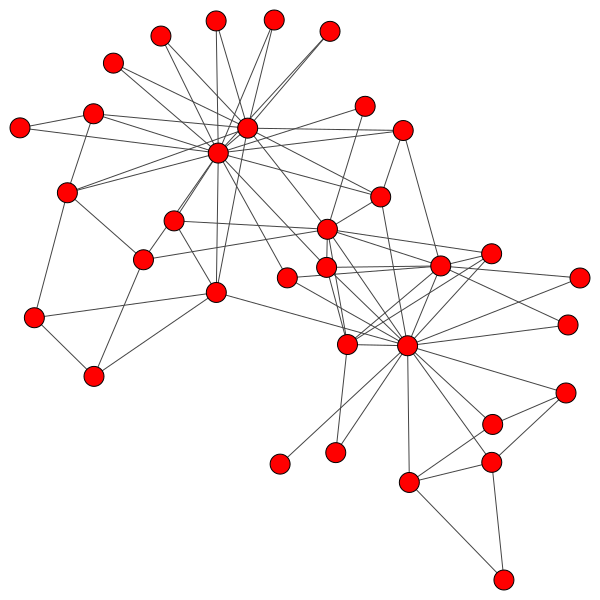

In [249]:
plot(g)

In [250]:
neighbors=[]
for i in range(34):
    temp=g.neighbors(vertex=i)
    neighbors.append(temp)

In [251]:
A=np.zeros((34,34))
for i in range(34):
    for j in range(34):
        if i==j:
            break
        if j in neighbors[i]:
            A[i][j]=1
            A[j][i]=1
A

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [252]:
similar=np.zeros((34,34))
for i in range(34):
    for j in range(34):
        p=[]
        q=[]
        for k in range(34):
            if(i in neighbors[k] and j in neighbors[k]):
                p.append(k)
            if(i in neighbors[k] or j in neighbors[k]):
                q.append(k)
        l1=len(p)
        l2=len(q)
        similar[i][j]=l1/l2
        similar[j][i]=l1/l2
similar

array([[1.        , 0.38888889, 0.23809524, ..., 0.        , 0.12      ,
        0.13793103],
       [0.38888889, 1.        , 0.26666667, ..., 0.07142857, 0.10526316,
        0.13043478],
       [0.23809524, 0.26666667, 1.        , ..., 0.23076923, 0.04761905,
        0.28571429],
       ...,
       [0.        , 0.07142857, 0.23076923, ..., 1.        , 0.05882353,
        0.0952381 ],
       [0.12      , 0.10526316, 0.04761905, ..., 0.05882353, 1.        ,
        0.52631579],
       [0.13793103, 0.13043478, 0.28571429, ..., 0.0952381 , 0.52631579,
        1.        ]])

In [253]:
for i in range(34):
    similar[i][i]=0

In [254]:
def cluster(sim):
    m = len(sim)
    max_s = 0
    x = 0
    y = 0
    # 选出最大相似度
    for i in range(m):
        for j in range(m):
            if(similar[i][j] > max_s):
                x = i
                y = j
                max_s = sim[i][j]
    # 全链算法更新相似度矩阵
    for i in range(m):
        similar[x][i] = min(similar[x][i], similar[y][i])
        similar[y][i] = min(similar[x][i], similar[y][i])
    return x, y	

In [255]:
Q_list=[]
degrees=g.degree()
def compute_Q(f, adjacency):
    Q = 0
    for i in range(M):
        for j in range(M):
            if f[i] == f[j]:
                Q += (adjacency[i][j]-(degrees[i]*degrees[j]/(2*M)))/(2*M)
            else:
                Q += 0
    Q_list.append(Q)
    return Q

In [256]:
def outputData(clusters,  edges):   # 输出无向图的连接关系，输出分类结果
    edge_out = []
    graph_file = 'graph.csv'
    name1 = ['nodea',  'edgetype',  'nodeb']
    for edge in edges:
        edge_out.append((edge[0]+1, 1, edge[1]+1))
    out1 = pd.DataFrame(columns=name1, data=edge_out)
    out1.to_csv(graph_file)

    attribute_file = 'class.csv'
    name2 = ['node',  'class']
    attribute_out = []
    for i in range(1, M+1):
        attribute_out.append((i, clusters[i-1]))
    out2 = pd.DataFrame(columns=name2,  data=attribute_out)
    out2.to_csv(attribute_file)

In [257]:
def draw():
    plt.figure(1)
    plt.plot(range(len(Q_list)),Q_list,color="b",linewidth=2)
    plt.xlabel('merge times')
    plt.ylabel("Q")
    plt.scatter(range(len(Q_list)),Q_list,linewidths=3,s=3,c='b')
    f1 = plt.gcf()
    plt.show()

In [258]:
clusters=[-1 for i in range(34)]
clusters[0]=-1
i=0
flag=0
Q=0
q_max=-1
edgelist=Graph.get_edgelist(g)
M=34

In [259]:
while(i < 100):
    x, y = cluster(similar)
    similar[x][y]=0
    if clusters[x] != -1 and clusters[y] != -1:   # x,y都已经分类，则将x, y的聚类合并成为一个，这里采用合并树的思想，将相同簇的节点遍历并进行修改
        temp = clusters[y]
        for j in range(M):
            if clusters[j] == temp:
                clusters[j] = clusters[x]
    if clusters[x] == -1 or clusters[y] == -1:      # 两个簇中至少有一个未分类
        if clusters[x] == -1 and clusters[y] == -1:     # 两个簇都未分类
            flag += 1                                 # 新建一个分类保存此簇
            clusters[x] = clusters[y] = flag
        elif clusters[x] == -1:                 # x未分类y已分类，将x并到y上去
            clusters[x] = clusters[y]
        elif clusters[y] == -1:                 # x已分类y未分类，将y并到x上去
            clusters[y] = clusters[x]
    Q = compute_Q(clusters, A)
    if(Q > q_max):		# 输出Q值最大的情况的分类
        outputData(clusters, edgelist)
        q_max = Q
    i += 1

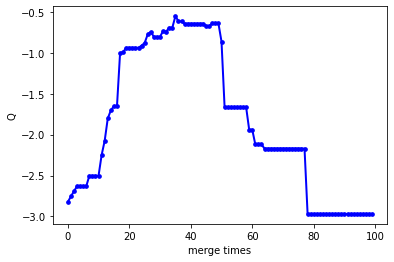

In [260]:
draw()